## Train dataset on MNIST :(

In [ ]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn

import torchvision.transforms as transforms

import numpy as np

import torchvision
import torch

In [3]:
from tqdm import tqdm

In [4]:
device = 'cuda'

In [5]:
from train_classifier import get_model

In [6]:
net = get_model("resnet101")

In [7]:
# net.load_state_dict(torch.load("./resnet18_mnist.pth"))
# net.load_state_dict(torch.load("./resnet50_mnist.pth"))
net.load_state_dict(torch.load("./resnet101_mnist.pth"))
net = net.to(device)

## Extract features from picture

In [8]:
import cv2
import matplotlib.pyplot as plt


from data_preprocessing import crop_and_warp, find_corners_of_largest_polygon, pre_process_image, remove_stuff


In [38]:
# img = cv2.imread("./sudoku_real_1.jpeg")

img = cv2.imread("./GM-Sudoku2.png")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

pre_preocessed = pre_process_image(gray)

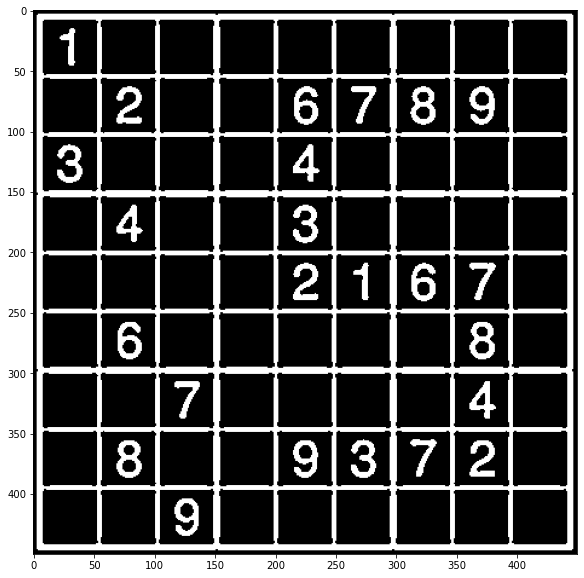

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(pre_preocessed, cmap='gray')



### Isolate area of the grid

In [40]:
corners = find_corners_of_largest_polygon(pre_preocessed)

In [41]:
cropped = crop_and_warp(pre_preocessed, corners)

## Solve sudoku!

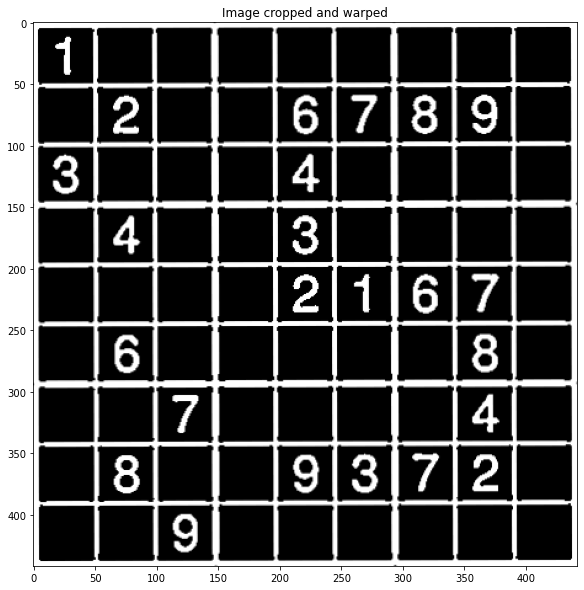

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(cropped, cmap='gray')
plt.title("Image cropped and warped");

In [43]:
_, cropped_t = cv2.threshold(cropped,127,255,cv2.THRESH_TOZERO)

In [44]:
cropped = cropped_t

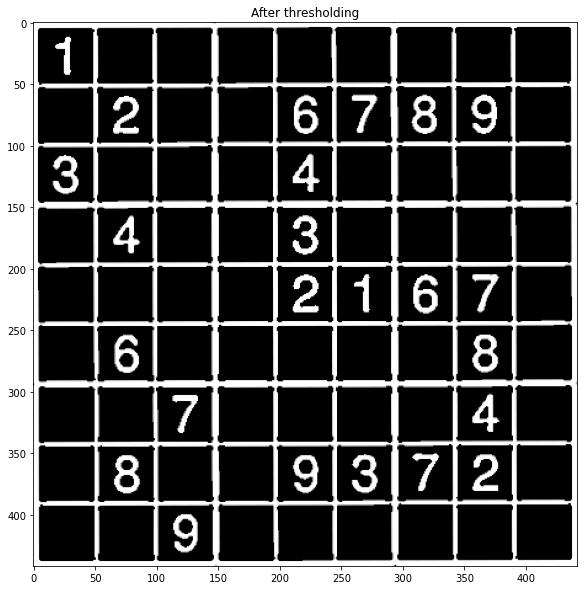

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(cropped_t, cmap='gray')
plt.title("After thresholding");

In [46]:
def slice_grid(grid, i, j, W):
    """
    Assuming grid is an array representing the image, return a single square
    based on its coordinates (which start from 0). 
    """
    
    i_start = i * W
    i_end = i_start + W
    
    j_start = j * W
    j_end = j_start + W
        
    aa = grid[i_start:i_end, j_start:j_end]
    return aa
    

In [47]:
w, h = cropped.shape

W = w//9


In [48]:
def smart_classify(resized, net, threshold=75, device='cuda', conf_threshold=0.9, debug=False):
    """
    First determined whether the cell is empty or not, checking the number of pixels different from zero.
    Then use a neural network to classify digits.
    """
    
    # Identify blank cells
    if (resized != resized.min()).sum() < threshold:
        return " "
    
    net.eval()
    iii = torch.Tensor(resized).to(device).unsqueeze(0).unsqueeze(0)
    
    with torch.no_grad():
        out = net(iii)
        sm = torch.nn.functional.softmax(out, dim=1)
        
    if debug:
        print(f"Logits: {out}")
        print(f"Softmax: {sm}")
        
    _, P = torch.max(out, 1)
    
    digit = P.item()
    conf = sm.squeeze()[digit].item()
    
    if debug:
        print(f"Predicted digit: {digit} with confidence {conf:.3f}")
    
    if digit != 0 and conf>conf_threshold:
        return str(digit)
    else:
        return " "    

In [49]:
w, h = cropped.shape

W = w//9

In [50]:
digits = list()

for i in range(9):
    
    for j in range(9):
        
        # Slice a cell from the original image
        aa = slice_grid(cropped_t, i, j, W)
        
        bb = aa.astype(float)/255

        # Isolate digit from rest of the cell
        out = remove_stuff(bb)
        
        # Resize to 28x28
        resized = cv2.resize(out, (28, 28), interpolation = cv2.INTER_AREA)
        digits.append(smart_classify(resized, net, conf_threshold=0.9))

In [51]:
def convert(d):
    if d == ' ':
        return 0
    else:
        return int(d)

In [52]:
from sudoku_solver import print_board, solve_array

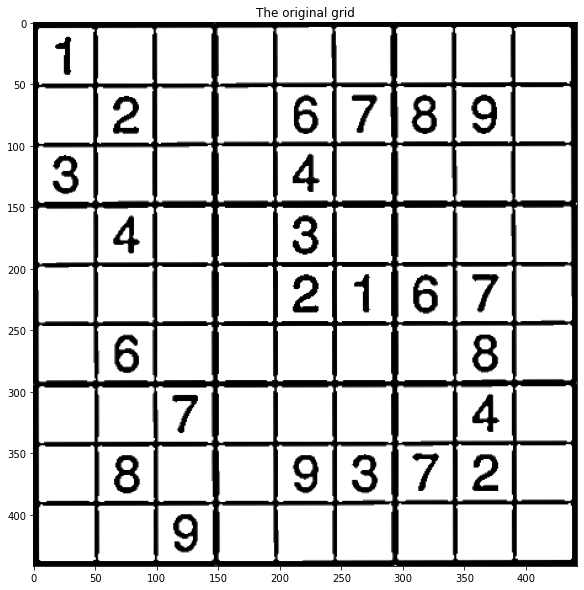

In [53]:
plt.figure(figsize=(10,10))
plt.imshow(255-cropped, cmap='gray')
plt.title("The original grid");

In [54]:
digits_int = np.array([convert(d) for d in digits])

digits_int = digits_int.reshape((9, 9))

In [55]:
digits_list = [list(ll) for ll in list(digits_int)]

In [56]:
print_board(digits_list)

7 . .  | . . .  | . . .
. 2 .  | . 6 7  | 8 9 .
3 . .  | . 4 .  | . . .
- - - - - - - - - - - - - 
. 4 .  | . 3 .  | . . .
. . .  | . 2 1  | 6 7 .
. 6 .  | . . .  | . . .
- - - - - - - - - - - - - 
. . 7  | . . .  | . 4 .
. 8 .  | . 9 3  | 7 2 .
. . .  | . . .  | . . .


In [57]:

digits_list = list(digits_list)

solve_array(digits_list)

False

In [58]:
print_board(digits_list)

7 . .  | . . .  | . . .
. 2 .  | . 6 7  | 8 9 .
3 . .  | . 4 .  | . . .
- - - - - - - - - - - - - 
. 4 .  | . 3 .  | . . .
. . .  | . 2 1  | 6 7 .
. 6 .  | . . .  | . . .
- - - - - - - - - - - - - 
. . 7  | . . .  | . 4 .
. 8 .  | . 9 3  | 7 2 .
. . .  | . . .  | . . .


## DEBUG

In [59]:
# Coordinates in the natural system (row, column values from 1 to 9)
coordinates = 5, 6

In [60]:
i, j = coordinates
i -= 1
j -= 1

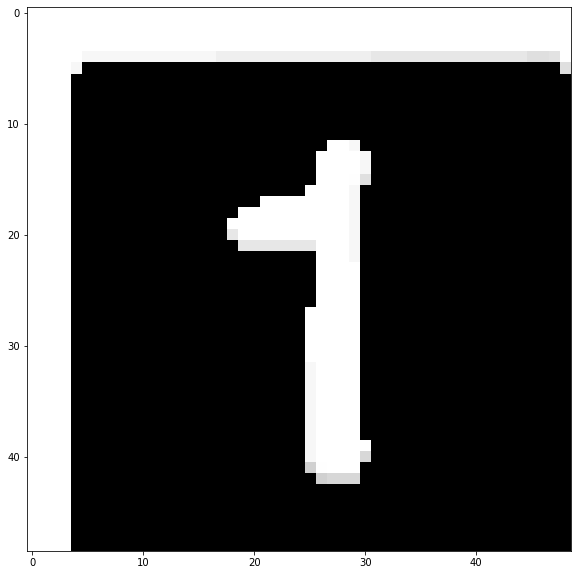

In [61]:
aa = slice_grid(cropped, i, j, W)
aa = aa.astype(np.float32)/255
plt.figure(figsize=(10,10))
plt.imshow(aa, cmap='gray')

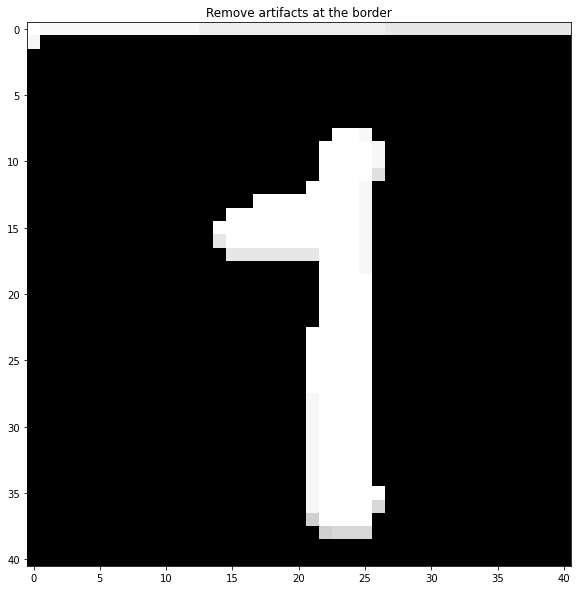

In [62]:
out = remove_stuff(aa)

plt.figure(figsize=(10,10))
plt.imshow(out, cmap='gray')
plt.title("Remove artifacts at the border");

In [63]:
resized = cv2.resize(out, (28, 28), interpolation = cv2.INTER_AREA)

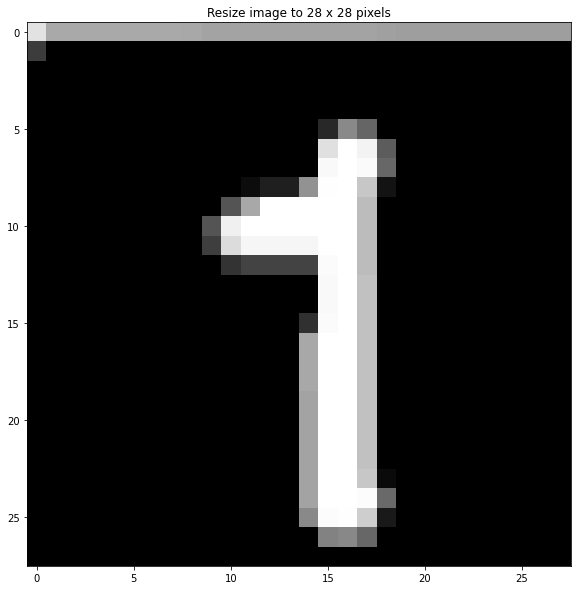

In [64]:
plt.figure(figsize=(10,10))
plt.imshow(resized, cmap='gray')
plt.title("Resize image to 28 x 28 pixels");

In [65]:
(resized != resized.min()).sum()

138

In [66]:
smart_classify(resized, net, debug=True)

Logits: tensor([[-3.9415,  0.5551, -0.5739, -2.6698,  0.8409, -3.1471, -4.0360,  6.9992,
         -2.9050,  1.0830]], device='cuda:0')
Softmax: tensor([[1.7598e-05, 1.5787e-03, 5.1046e-04, 6.2766e-05, 2.1008e-03, 3.8942e-05,
         1.6010e-05, 9.9295e-01, 4.9613e-05, 2.6764e-03]], device='cuda:0')
Predicted digit: 7 with confidence 0.993


'7'